# Customer Churn Model - Classification

In [28]:
#Importing libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Input data files are available in the "../input/" directory.
import os
import matplotlib.pyplot as plt#visualization
from PIL import  Image
%matplotlib inline
import pandas as pd
import seaborn as sns#visualization
import itertools
import warnings
warnings.filterwarnings("ignore")
import io
import plotly.offline as py#visualization
py.init_notebook_mode(connected=True)#visualization
import plotly.graph_objs as go#visualization
import plotly.tools as tls#visualization
import plotly.tools as tls_u#visualization
import plotly.figure_factory as ff#visualization

## Data

In [2]:
telcom = pd.read_csv(r"Data/Telco-Customer-Churn.csv")
#first few rows
telcom.head()

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No        One year               No   
2          No          No              No  Month-to-month              Yes   
3         Yes          No              No        One year               No   
4          No          No              No  Month-to-month              Yes   

               PaymentMethod MonthlyCharges  TotalCharges Churn  
0           Electronic check          29.85         29.85    No  
1               Mailed check          56.95        1889.5    No  
2               Mailed check          53.85        108.15   Yes  
3  Bank transfer (automatic)          42.30       1840.75    No  
4           Electronic check          70.70        151.65   Yes  

[5 rows x 21 columns]

### Data overview

In [3]:
# Check columns types
telcom.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [4]:
print ("Rows     : " ,telcom.shape[0])
print ("Columns  : " ,telcom.shape[1])
print ("\nFeatures : \n" ,telcom.columns.tolist())
print ("\nMissing values :  ", telcom.isnull().sum().values.sum())
print ("\nUnique values :  \n",telcom.nunique())

Rows     :  7043
Columns  :  21

Features : 
 ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']

Missing values :   0

Unique values :  
 customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64


## Data Manipulation

In [5]:
(telcom['TotalCharges']==" ").sum()

11

In [6]:
#Data Manipulation

#Replacing spaces with null values in total charges column
telcom['TotalCharges'] = telcom["TotalCharges"].replace(" ",np.nan)

#Dropping null values from total charges column which contain .15% missing data 
telcom = telcom[telcom["TotalCharges"].notnull()]
telcom = telcom.reset_index()[telcom.columns]

#convert to float type
telcom["TotalCharges"] = telcom["TotalCharges"].astype(float)

#replace 'No internet service' to No for the following columns
replace_cols = [ 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                'TechSupport','StreamingTV', 'StreamingMovies']
for i in replace_cols : 
    telcom[i]  = telcom[i].replace({'No internet service' : 'No'})
    
#replace values
telcom["SeniorCitizen"] = telcom["SeniorCitizen"].replace({1:"Yes",0:"No"})

#Tenure to categorical column
def tenure_lab(telcom) :
    
    if telcom["tenure"] <= 12 :
        return "Tenure_0-12"
    elif (telcom["tenure"] > 12) & (telcom["tenure"] <= 24 ):
        return "Tenure_12-24"
    elif (telcom["tenure"] > 24) & (telcom["tenure"] <= 48) :
        return "Tenure_24-48"
    elif (telcom["tenure"] > 48) & (telcom["tenure"] <= 60) :
        return "Tenure_48-60"
    elif telcom["tenure"] > 60 :
        return "Tenure_gt_60"
telcom["tenure_group"] = telcom.apply(lambda telcom:tenure_lab(telcom),
                                      axis = 1)

#Separating churn and non churn customers
churn     = telcom[telcom["Churn"] == "Yes"]
not_churn = telcom[telcom["Churn"] == "No"]


In [8]:
cat_cols   = telcom.nunique()[telcom.nunique() < 6].keys().tolist()
telcom.nunique()[telcom.nunique() < 6].keys().tolist()

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'Churn',
 'tenure_group']

In [9]:
#Separating catagorical and numerical columns
Id_col     = ['customerID']
target_col = ["Churn"]
cat_cols   = telcom.nunique()[telcom.nunique() < 6].keys().tolist()
cat_cols   = [x for x in cat_cols if x not in target_col]
num_cols   = [x for x in telcom.columns if x not in cat_cols + target_col + Id_col]

## Exploratory Data Analysis

### Customer Attrition

In [11]:
telcom["Churn"].value_counts()

No     5163
Yes    1869
Name: Churn, dtype: int64

In [12]:
#labels
lab = telcom["Churn"].value_counts().keys().tolist()
#values
val = telcom["Churn"].value_counts().values.tolist()

trace = go.Pie(labels = lab ,
               values = val ,
               marker = dict(colors =  [ 'royalblue' ,'lime'],
                             line = dict(color = "white",
                                         width =  1.3)
                            ),
               rotation = 90,
               hoverinfo = "label+value+text",
               hole = .5
              )
layout = go.Layout(dict(title = "Customer attrition in data",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                       )
                  )

data = [trace]
fig = go.Figure(data = data,layout = layout)
py.iplot(fig)

### Variable distribution in Customer Attrition

In [13]:
#function  for pie plot for customer attrition types
def plot_pie(column) :
    
    trace1 = go.Pie(values  = churn[column].value_counts().values.tolist(),
                    labels  = churn[column].value_counts().keys().tolist(),
                    hoverinfo = "label+percent+name",
                    domain  = dict(x = [0,.48]),
                    name    = "Churn Customers",
                    marker  = dict(line = dict(width = 2,
                                               color = "rgb(243,243,243)")
                                  ),
                    hole    = .6
                   )
    trace2 = go.Pie(values  = not_churn[column].value_counts().values.tolist(),
                    labels  = not_churn[column].value_counts().keys().tolist(),
                    hoverinfo = "label+percent+name",
                    marker  = dict(line = dict(width = 2,
                                               color = "rgb(243,243,243)")
                                  ),
                    domain  = dict(x = [.52,1]),
                    hole    = .6,
                    name    = "Non churn customers" 
                   )


    layout = go.Layout(dict(title = column + " distribution in customer attrition ",
                            plot_bgcolor  = "rgb(243,243,243)",
                            paper_bgcolor = "rgb(243,243,243)",
                            annotations = [dict(text = "churn customers",
                                                font = dict(size = 13),
                                                showarrow = False,
                                                x = .15, y = .5),
                                           dict(text = "Non churn customers",
                                                font = dict(size = 13),
                                                showarrow = False,
                                                x = .88,y = .5
                                               )
                                          ]
                           )
                      )
    data = [trace1,trace2]
    fig  = go.Figure(data = data,layout = layout)
    py.iplot(fig)


#function  for histogram for customer attrition types
def histogram(column) :
    trace1 = go.Histogram(x  = churn[column],
                          histnorm= "percent",
                          name = "Churn Customers",
                          marker = dict(line = dict(width = .5,
                                                    color = "black"
                                                    )
                                        ),
                         opacity = .9 
                         ) 
    
    trace2 = go.Histogram(x  = not_churn[column],
                          histnorm = "percent",
                          name = "Non churn customers",
                          marker = dict(line = dict(width = .5,
                                              color = "black"
                                             )
                                 ),
                          opacity = .9
                         )
    
    data = [trace1,trace2]
    layout = go.Layout(dict(title =column + " distribution in customer attrition ",
                            plot_bgcolor  = "rgb(243,243,243)",
                            paper_bgcolor = "rgb(243,243,243)",
                            xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                             title = column,
                                             zerolinewidth=1,
                                             ticklen=5,
                                             gridwidth=2
                                            ),
                            yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                             title = "percent",
                                             zerolinewidth=1,
                                             ticklen=5,
                                             gridwidth=2
                                            ),
                           )
                      )
    fig  = go.Figure(data=data,layout=layout)
    
    py.iplot(fig)
    
#function  for scatter plot matrix  for numerical columns in data
def scatter_matrix(df)  :
    
    df  = df.sort_values(by = "Churn" ,ascending = True)
    classes = df["Churn"].unique().tolist()
    classes
    
    class_code  = {classes[k] : k for k in range(2)}
    class_code

    color_vals = [class_code[cl] for cl in df["Churn"]]
    color_vals

    pl_colorscale = "Portland"

    pl_colorscale

    text = [df.loc[k,"Churn"] for k in range(len(df))]
    text

    trace = go.Splom(dimensions = [dict(label  = "tenure",
                                       values = df["tenure"]),
                                  dict(label  = 'MonthlyCharges',
                                       values = df['MonthlyCharges']),
                                  dict(label  = 'TotalCharges',
                                       values = df['TotalCharges'])],
                     text = text,
                     marker = dict(color = color_vals,
                                   colorscale = pl_colorscale,
                                   size = 3,
                                   showscale = False,
                                   line = dict(width = .1,
                                               color='rgb(230,230,230)'
                                              )
                                  )
                    )
    axis = dict(showline  = True,
                zeroline  = False,
                gridcolor = "#fff",
                ticklen   = 4
               )
    
    layout = go.Layout(dict(title  = 
                            "Scatter plot matrix for Numerical columns for customer attrition",
                            autosize = False,
                            height = 800,
                            width  = 800,
                            dragmode = "select",
                            hovermode = "closest",
                            plot_bgcolor  = 'rgba(240,240,240, 0.95)',
                            xaxis1 = dict(axis),
                            yaxis1 = dict(axis),
                            xaxis2 = dict(axis),
                            yaxis2 = dict(axis),
                            xaxis3 = dict(axis),
                            yaxis3 = dict(axis),
                           )
                      )
    data   = [trace]
    fig = go.Figure(data = data,layout = layout )
    py.iplot(fig)

#for all categorical columns plot pie
for i in cat_cols :
    plot_pie(i)

#for all categorical columns plot histogram    
for i in num_cols :
    histogram(i)

#scatter plot matrix
scatter_matrix(telcom)

### Customer Attrition in Tenure Groups

In [14]:
#cusomer attrition in tenure groups
tg_ch  =  churn["tenure_group"].value_counts().reset_index()
tg_ch.columns  = ["tenure_group","count"]
tg_nch =  not_churn["tenure_group"].value_counts().reset_index()
tg_nch.columns = ["tenure_group","count"]

#bar - churn
trace1 = go.Bar(x = tg_ch["tenure_group"]  , y = tg_ch["count"],
                name = "Churn Customers",
                marker = dict(line = dict(width = .5,color = "black")),
                opacity = .9)

#bar - not churn
trace2 = go.Bar(x = tg_nch["tenure_group"] , y = tg_nch["count"],
                name = "Non Churn Customers",
                marker = dict(line = dict(width = .5,color = "black")),
                opacity = .9)

layout = go.Layout(dict(title = "Customer attrition in tenure groups",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                        xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     title = "tenure group",
                                     zerolinewidth=1,ticklen=5,gridwidth=2),
                        yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     title = "count",
                                     zerolinewidth=1,ticklen=5,gridwidth=2),
                       )
                  )
data = [trace1,trace2]
fig  = go.Figure(data=data,layout=layout)
py.iplot(fig)

### Monthly Charges and Total Charges by Tenure and Chrun Group

In [15]:
telcom[['MonthlyCharges', 'TotalCharges','tenure',"tenure_group"]]

#scatter plot monthly charges & total charges by tenure group

def plot_tenure_scatter(tenure_group,color) :
    tracer = go.Scatter(x = telcom[telcom["tenure_group"] == tenure_group]["MonthlyCharges"],
                        y = telcom[telcom["tenure_group"] == tenure_group]["TotalCharges"],
                        mode = "markers",marker = dict(line = dict(color = "black",
                                                                   width = .2),
                                                       size = 4 , color = color,
                                                       symbol = "diamond-dot",
                                                      ),
                        name = tenure_group,
                        opacity = .9
                       )
    return tracer

#scatter plot monthly charges & total charges by churn group
def plot_churncharges_scatter(churn,color) :
    tracer = go.Scatter(x = telcom[telcom["Churn"] == churn]["MonthlyCharges"],
                        y = telcom[telcom["Churn"] == churn]["TotalCharges"],
                        mode = "markers",marker = dict(line = dict(color = "black",
                                                                   width = .2),
                                                       size = 4 , color = color,
                                                       symbol = "diamond-dot",
                                                      ),
                        name = "Churn - " + churn,
                        opacity = .9
                       )
    return tracer

trace1 = plot_tenure_scatter("Tenure_0-12","#FF3300")
trace2 = plot_tenure_scatter("Tenure_12-24","#6666FF")
trace3 = plot_tenure_scatter("Tenure_24-48","#99FF00")
trace4 = plot_tenure_scatter("Tenure_48-60","#996600")
trace5 = plot_tenure_scatter("Tenure_gt_60","grey")
trace6 = plot_churncharges_scatter("Yes","red")
trace7 = plot_churncharges_scatter("No","blue")

data1   = [trace1,trace2,trace3,trace4,trace5] 
data2   = [trace7,trace6]

#layout
def layout_title(title) :
    layout = go.Layout(dict(title = title,
                            plot_bgcolor  = "rgb(243,243,243)",
                            paper_bgcolor = "rgb(243,243,243)",
                            xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                         title = "Monthly charges",
                                         zerolinewidth=1,ticklen=5,gridwidth=2),
                            yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                         title = "Total Charges",
                                         zerolinewidth=1,ticklen=5,gridwidth=2),
                            height = 600
                           )
                      )
    return layout

layout1  = layout_title("Monthly Charges & Total Charges by Tenure group")
layout2  = layout_title("Monthly Charges & Total Charges by Churn group")
fig1 = go.Figure(data = data1,layout = layout1)
fig2 = go.Figure(data = data2,layout = layout2)
py.iplot(fig1)
py.iplot(fig2)

### Average Charges by Tenure Group

In [16]:
avg_tgc = telcom.groupby(["tenure_group","Churn"])[["MonthlyCharges",
                                                    "TotalCharges"]].mean().reset_index()

#function for tracing 
def mean_charges(column,aggregate) :
    tracer = go.Bar(x = avg_tgc[avg_tgc["Churn"] == aggregate]["tenure_group"],
                    y = avg_tgc[avg_tgc["Churn"] == aggregate][column],
                    name = aggregate,marker = dict(line = dict(width = 1)),
                    text = "Churn"
                   )
    return tracer

#function for layout
def layout_plot(title,xaxis_lab,yaxis_lab) :
    layout = go.Layout(dict(title = title,
                            plot_bgcolor  = "rgb(243,243,243)",
                            paper_bgcolor = "rgb(243,243,243)",
                            xaxis = dict(gridcolor = 'rgb(255, 255, 255)',title = xaxis_lab,
                                         zerolinewidth=1,ticklen=5,gridwidth=2),
                            yaxis = dict(gridcolor = 'rgb(255, 255, 255)',title = yaxis_lab,
                                         zerolinewidth=1,ticklen=5,gridwidth=2),
                           )
                      )
    return layout
    

#plot1 - mean monthly charges by tenure groups
trace1  = mean_charges("MonthlyCharges","Yes")
trace2  = mean_charges("MonthlyCharges","No")
layout1 = layout_plot("Average Monthly Charges by Tenure groups",
                      "Tenure group","Monthly Charges")
data1   = [trace1,trace2]
fig1    = go.Figure(data=data1,layout=layout1)

#plot2 - mean total charges by tenure groups
trace3  = mean_charges("TotalCharges","Yes")
trace4  = mean_charges("TotalCharges","No")
layout2 = layout_plot("Average Total Charges by Tenure groups",
                      "Tenure group","Total Charges")
data2   = [trace3,trace4]
fig2    = go.Figure(data=data2,layout=layout2)

py.iplot(fig1)
py.iplot(fig2)

### Monthly Charges, Total Charges and Tenure in Customer Attrition

In [18]:
##copy data
tel_df = telcom.copy()
#Drop tenure column
telcom = telcom.drop(columns = "tenure_group",axis = 1)

trace1 = go.Scatter3d(x = churn["MonthlyCharges"],
                      y = churn["TotalCharges"],
                      z = churn["tenure"],
                      mode = "markers",
                      name = "Churn customers",
                      text = "Id : " + churn["customerID"],
                      marker = dict(size = 1,color = "red")
                     )
trace2 = go.Scatter3d(x = not_churn["MonthlyCharges"],
                      y = not_churn["TotalCharges"],
                      z = not_churn["tenure"],
                      name = "Non churn customers",
                      text = "Id : " + not_churn["customerID"],
                      mode = "markers",
                      marker = dict(size = 1,color= "green")
                     )



layout = go.Layout(dict(title = "Monthly charges,total charges & tenure in customer attrition",
                        scene = dict(camera = dict(up=dict(x= 0 , y=0, z=0),
                                                   center=dict(x=0, y=0, z=0),
                                                   eye=dict(x=1.25, y=1.25, z=1.25)),
                                     xaxis  = dict(title = "monthly charges",
                                                   gridcolor='rgb(255, 255, 255)',
                                                   zerolinecolor='rgb(255, 255, 255)',
                                                   showbackground=True,
                                                   backgroundcolor='rgb(230, 230,230)'),
                                     yaxis  = dict(title = "total charges",
                                                   gridcolor='rgb(255, 255, 255)',
                                                   zerolinecolor='rgb(255, 255, 255)',
                                                   showbackground=True,
                                                   backgroundcolor='rgb(230, 230,230)'
                                                  ),
                                     zaxis  = dict(title = "tenure",
                                                   gridcolor='rgb(255, 255, 255)',
                                                   zerolinecolor='rgb(255, 255, 255)',
                                                   showbackground=True,
                                                   backgroundcolor='rgb(230, 230,230)'
                                                  )
                                    ),
                        height = 700,
                       )
                  )
                  

data = [trace1,trace2]
fig  = go.Figure(data = data,layout = layout)
py.iplot(fig)

## Data Preprocessing

In [19]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

#customer id col
Id_col     = ['customerID']
#Target columns
target_col = ["Churn"]
#categorical columns
cat_cols   = telcom.nunique()[telcom.nunique() < 6].keys().tolist()
cat_cols   = [x for x in cat_cols if x not in target_col]
#numerical columns
num_cols   = [x for x in telcom.columns if x not in cat_cols + target_col + Id_col]
#Binary columns with 2 values
bin_cols   = telcom.nunique()[telcom.nunique() == 2].keys().tolist()
#Columns more than 2 values
multi_cols = [i for i in cat_cols if i not in bin_cols]

#Label encoding Binary columns
le = LabelEncoder()
for i in bin_cols :
    telcom[i] = le.fit_transform(telcom[i])
    
#Duplicating columns for multi value columns
telcom = pd.get_dummies(data = telcom,columns = multi_cols )

#Scaling Numerical columns
std = StandardScaler()
scaled = std.fit_transform(telcom[num_cols])
scaled = pd.DataFrame(scaled,columns=num_cols)

#dropping original values merging scaled values for numerical columns
df_telcom_og = telcom.copy()
telcom = telcom.drop(columns = num_cols,axis = 1)
telcom = telcom.merge(scaled,left_index=True,right_index=True,how = "left")

### Variable Summary

In [20]:
summary = (df_telcom_og[[i for i in df_telcom_og.columns if i not in Id_col]].
           describe().transpose().reset_index())

summary = summary.rename(columns = {"index" : "feature"})
summary = np.around(summary,3)

val_lst = [summary['feature'], summary['count'],
           summary['mean'],summary['std'],
           summary['min'], summary['25%'],
           summary['50%'], summary['75%'], summary['max']]

trace  = go.Table(header = dict(values = summary.columns.tolist(),
                                line = dict(color = ['#506784']),
                                fill = dict(color = ['#119DFF']),
                               ),
                  cells  = dict(values = val_lst,
                                line = dict(color = ['#506784']),
                                fill = dict(color = ["lightgrey",'#F5F8FF'])
                               ),
                  columnwidth = [200,60,100,100,60,60,80,80,80])
layout = go.Layout(dict(title = "Variable Summary"))
figure = go.Figure(data=[trace],layout=layout)
py.iplot(figure)


### Correlation Matrix

In [21]:
#correlation
correlation = telcom.corr()
#tick labels
matrix_cols = correlation.columns.tolist()
#convert to array
corr_array  = np.array(correlation)

#Plotting
trace = go.Heatmap(z = corr_array,
                   x = matrix_cols,
                   y = matrix_cols,
                   colorscale = "Viridis",
                   colorbar   = dict(title = "Pearson Correlation coefficient",
                                     titleside = "right"
                                    ) ,
                  )

layout = go.Layout(dict(title = "Correlation Matrix for variables",
                        autosize = False,
                        height  = 720,
                        width   = 800,
                        margin  = dict(r = 0 ,l = 210,
                                       t = 25,b = 210,
                                      ),
                        yaxis   = dict(tickfont = dict(size = 9)),
                        xaxis   = dict(tickfont = dict(size = 9))
                       )
                  )

data = [trace]
fig = go.Figure(data=data,layout=layout)
py.iplot(fig)

### Visualizing Data with Principal Components

In [22]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)

X = telcom[[i for i in telcom.columns if i not in Id_col + target_col]]
Y = telcom[target_col + Id_col]

principal_components = pca.fit_transform(X)
pca_data = pd.DataFrame(principal_components,columns = ["PC1","PC2"])
pca_data = pca_data.merge(Y,left_index=True,right_index=True,how="left")
pca_data["Churn"] = pca_data["Churn"].replace({1:"Churn",0:"Not Churn"})

def pca_scatter(target,color) :
    tracer = go.Scatter(x = pca_data[pca_data["Churn"] == target]["PC1"] ,
                        y = pca_data[pca_data["Churn"] == target]["PC2"],
                        name = target,mode = "markers",
                        marker = dict(color = color,
                                      line = dict(width = .5),
                                      symbol =  "diamond-open"),
                        text = ("Customer Id : " + 
                                pca_data[pca_data["Churn"] == target]['customerID'])
                       )
    return tracer

layout = go.Layout(dict(title = "Visualising data with principal components",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                        xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     title = "principal component 1",
                                     zerolinewidth=1,ticklen=5,gridwidth=2),
                        yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     title = "principal component 2",
                                     zerolinewidth=1,ticklen=5,gridwidth=2),
                        height = 600
                       )
                  )
trace1 = pca_scatter("Churn",'red')
trace2 = pca_scatter("Not Churn",'royalblue')
data = [trace2,trace1]
fig = go.Figure(data=data,layout=layout)
py.iplot(fig)

### Binary variables distribution in customer attrition(Radar Chart)

In [23]:
#separating binary columns
bi_cs = telcom.nunique()[telcom.nunique() == 2].keys()
dat_rad = telcom[bi_cs]

#plotting radar chart for churn and non churn customers(binary variables)
def plot_radar(df,aggregate,title) :
    data_frame = df[df["Churn"] == aggregate] 
    data_frame_x = data_frame[bi_cs].sum().reset_index()
    data_frame_x.columns  = ["feature","yes"]
    data_frame_x["no"]    = data_frame.shape[0]  - data_frame_x["yes"]
    data_frame_x  = data_frame_x[data_frame_x["feature"] != "Churn"]
    
    #count of 1's(yes)
    trace1 = go.Scatterpolar(r = data_frame_x["yes"].values.tolist(),
                             theta = data_frame_x["feature"].tolist(),
                             fill  = "toself",name = "count of 1's",
                             mode = "markers+lines",
                             marker = dict(size = 5)
                            )
    #count of 0's(No)
    trace2 = go.Scatterpolar(r = data_frame_x["no"].values.tolist(),
                             theta = data_frame_x["feature"].tolist(),
                             fill  = "toself",name = "count of 0's",
                             mode = "markers+lines",
                             marker = dict(size = 5)
                            ) 
    layout = go.Layout(dict(polar = dict(radialaxis = dict(visible = True,
                                                           side = "counterclockwise",
                                                           showline = True,
                                                           linewidth = 2,
                                                           tickwidth = 2,
                                                           gridcolor = "white",
                                                           gridwidth = 2),
                                         angularaxis = dict(tickfont = dict(size = 10),
                                                            layer = "below traces"
                                                           ),
                                         bgcolor  = "rgb(243,243,243)",
                                        ),
                            paper_bgcolor = "rgb(243,243,243)",
                            title = title,height = 700))
    
    data = [trace2,trace1]
    fig = go.Figure(data=data,layout=layout)
    py.iplot(fig)

#plot
plot_radar(dat_rad,1,"Churn -  Customers")
plot_radar(dat_rad,0,"Non Churn - Customers")

## Model Building

### Baseline Model

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
                   solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

 Classification report : 
               precision    recall  f1-score   support

           0       0.83      0.90      0.87      1268
           1       0.68      0.54      0.60       490

    accuracy                           0.80      1758
   macro avg       0.76      0.72      0.73      1758
weighted avg       0.79      0.80      0.79      1758

Accuracy   Score :  0.8003412969283277
Area under curve :  0.7194714478851477 



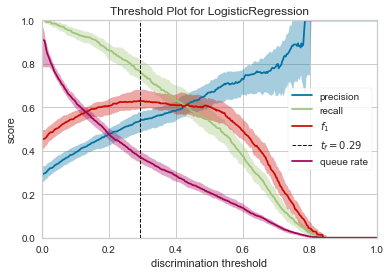

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.metrics import roc_auc_score,roc_curve,scorer
from sklearn.metrics import f1_score
import statsmodels.api as sm
from sklearn.metrics import precision_score,recall_score
from yellowbrick.classifier import DiscriminationThreshold
#splitting train and test data 
train,test = train_test_split(telcom,test_size = .25 ,random_state = 111)
    
##seperating dependent and independent variables
cols    = [i for i in telcom.columns if i not in Id_col + target_col]
train_X = train[cols]
train_Y = train[target_col]
test_X  = test[cols]
test_Y  = test[target_col]

#Function attributes
#dataframe     - processed dataframe
#Algorithm     - Algorithm used 
#training_x    - predictor variables dataframe(training)
#testing_x     - predictor variables dataframe(testing)
#training_y    - target variable(training)
#training_y    - target variable(testing)
#cf - ["coefficients","features"](cooefficients for logistic 
                                 #regression,features for tree based models)

#threshold_plot - if True returns threshold plot for model
    
def telecom_churn_prediction(algorithm,training_x,testing_x,
                             training_y,testing_y,cols,cf,threshold_plot) :
    
    #model
    algorithm.fit(training_x,training_y)
    predictions   = algorithm.predict(testing_x)
    probabilities = algorithm.predict_proba(testing_x)
    #coeffs
    if   cf == "coefficients" :
        coefficients  = pd.DataFrame(algorithm.coef_.ravel())
    elif cf == "features" :
        coefficients  = pd.DataFrame(algorithm.feature_importances_)
        
    column_df     = pd.DataFrame(cols)
    coef_sumry    = (pd.merge(coefficients,column_df,left_index= True,
                              right_index= True, how = "left"))
    coef_sumry.columns = ["coefficients","features"]
    coef_sumry    = coef_sumry.sort_values(by = "coefficients",ascending = False)
    
    print (algorithm)
    print ("\n Classification report : \n",classification_report(testing_y,predictions))
    print ("Accuracy   Score : ",accuracy_score(testing_y,predictions))
    #confusion matrix
    conf_matrix = confusion_matrix(testing_y,predictions)
    #roc_auc_score
    model_roc_auc = roc_auc_score(testing_y,predictions) 
    print ("Area under curve : ",model_roc_auc,"\n")
    fpr,tpr,thresholds = roc_curve(testing_y,probabilities[:,1])
    
    #plot confusion matrix
    trace1 = go.Heatmap(z = conf_matrix ,
                        x = ["Not churn","Churn"],
                        y = ["Not churn","Churn"],
                        showscale  = False,colorscale = "Picnic",
                        name = "matrix")
    
    #plot roc curve
    trace2 = go.Scatter(x = fpr,y = tpr,
                        name = "Roc : " + str(model_roc_auc),
                        line = dict(color = ('rgb(22, 96, 167)'),width = 2))
    trace3 = go.Scatter(x = [0,1],y=[0,1],
                        line = dict(color = ('rgb(205, 12, 24)'),width = 2,
                        dash = 'dot'))
    
    #plot coeffs
    trace4 = go.Bar(x = coef_sumry["features"],y = coef_sumry["coefficients"],
                    name = "coefficients",
                    marker = dict(color = coef_sumry["coefficients"],
                                  colorscale = "Picnic",
                                  line = dict(width = .6,color = "black")))
    
    #subplots
    fig = tls_u.make_subplots(rows=2, cols=2, specs=[[{}, {}], [{'colspan': 2}, None]],
                            subplot_titles=('Confusion Matrix',
                                            'Receiver operating characteristic',
                                            'Feature Importances'))
    
    fig.append_trace(trace1,1,1)
    fig.append_trace(trace2,1,2)
    fig.append_trace(trace3,1,2)
    fig.append_trace(trace4,2,1)
    
    fig['layout'].update(showlegend=False, title="Model performance" ,
                         autosize = False,height = 900,width = 800,
                         plot_bgcolor = 'rgba(240,240,240, 0.95)',
                         paper_bgcolor = 'rgba(240,240,240, 0.95)',
                         margin = dict(b = 195))
    fig["layout"]["xaxis2"].update(dict(title = "false positive rate"))
    fig["layout"]["yaxis2"].update(dict(title = "true positive rate"))
    fig["layout"]["xaxis3"].update(dict(showgrid = True,tickfont = dict(size = 10),
                                        tickangle = 90))
    py.iplot(fig)
    
    if threshold_plot == True : 
        visualizer = DiscriminationThreshold(algorithm)
        visualizer.fit(training_x,training_y)
        visualizer.poof()
        
logit  = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

telecom_churn_prediction(logit,train_X,test_X,train_Y,test_Y,
                         cols,"coefficients",threshold_plot = True)



### Synthetic Minority Oversampling TEchnique (SMOTE)
* Randomly pick a point from the minority class.
* Compute the k-nearest neighbors (for some pre-specified k) for this point.
* Add k new points somewhere between the chosen point and each of its neighbors

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
                   solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

 Classification report : 
               precision    recall  f1-score   support

           0       0.88      0.80      0.84      1268
           1       0.59      0.72      0.65       490

    accuracy                           0.78      1758
   macro avg       0.73      0.76      0.74      1758
weighted avg       0.80      0.78      0.79      1758

Accuracy   Score :  0.7798634812286689
Area under curve :  0.7609975535955706 



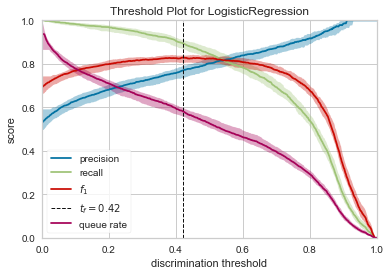

In [30]:
from imblearn.over_sampling import SMOTE

cols    = [i for i in telcom.columns if i not in Id_col+target_col]

smote_X = telcom[cols]
smote_Y = telcom[target_col]

#Split train and test data
smote_train_X,smote_test_X,smote_train_Y,smote_test_Y = train_test_split(smote_X,smote_Y,
                                                                         test_size = .25 ,
                                                                         random_state = 111)

#oversampling minority class using smote
os = SMOTE(random_state = 0)
os_smote_X,os_smote_Y = os.fit_sample(smote_train_X,smote_train_Y)
os_smote_X = pd.DataFrame(data = os_smote_X,columns=cols)
os_smote_Y = pd.DataFrame(data = os_smote_Y,columns=target_col)
###



logit_smote = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

telecom_churn_prediction(logit_smote,os_smote_X,test_X,os_smote_Y,test_Y,
                         cols,"coefficients",threshold_plot = True)

### Recursive Feature Elimination
Recursive Feature Elimination (RFE) is based on the idea to repeatedly construct a model and choose either the best or worst performing feature, setting the feature aside and then repeating the process with the rest of the features. This process is applied until all features in the dataset are exhausted. The goal of RFE is to select features by recursively considering smaller and smaller sets of features.

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
                   solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

 Classification report : 
               precision    recall  f1-score   support

           0       0.89      0.71      0.79      1268
           1       0.51      0.77      0.61       490

    accuracy                           0.73      1758
   macro avg       0.70      0.74      0.70      1758
weighted avg       0.78      0.73      0.74      1758

Accuracy   Score :  0.7303754266211604
Area under curve :  0.7429698062190175 



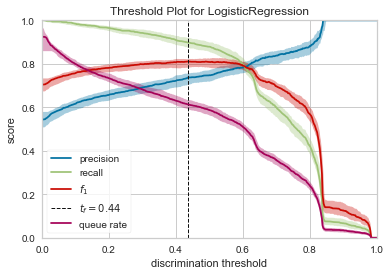

In [31]:
from sklearn.feature_selection import RFE

logit = LogisticRegression()

rfe = RFE(logit,10)
rfe = rfe.fit(os_smote_X,os_smote_Y.values.ravel())

rfe.support_
rfe.ranking_

#identified columns Recursive Feature Elimination
idc_rfe = pd.DataFrame({"rfe_support" :rfe.support_,
                       "columns" : [i for i in telcom.columns if i not in Id_col + target_col],
                       "ranking" : rfe.ranking_,
                      })
cols = idc_rfe[idc_rfe["rfe_support"] == True]["columns"].tolist()


#separating train and test data
train_rf_X = os_smote_X[cols]
train_rf_Y = os_smote_Y
test_rf_X  = test[cols]
test_rf_Y  = test[target_col]

logit_rfe = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
#applying model
telecom_churn_prediction(logit_rfe,train_rf_X,test_rf_X,train_rf_Y,test_rf_Y,
                         cols,"coefficients",threshold_plot = True)

tab_rk = ff.create_table(idc_rfe)
py.iplot(tab_rk)

### Univariate Selection
* Feature Extraction with Univariate Statistical Tests (Chi-squared for classification)
* uses the chi squared (chi^2) statistical test for non-negative features to select the best features

In [32]:
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest

#select columns
cols = [i for i in telcom.columns if i not in Id_col + target_col ]

#dataframe with non negative values
df_x = df_telcom_og[cols]
df_y = df_telcom_og[target_col]

#fit model with k= 3
select = SelectKBest(score_func = chi2,k = 3)
fit    = select.fit(df_x,df_y)

#Summerize scores
print ("scores")
print (fit.scores_)
print ("P - Values")
print (fit.pvalues_)

#create dataframe
score = pd.DataFrame({"features":cols,"scores":fit.scores_,"p_values":fit.pvalues_ })
score = score.sort_values(by = "scores" ,ascending =False)


#createing new label for categorical and numerical columns
score["feature_type"] = np.where(score["features"].isin(num_cols),"Numerical","Categorical")

#plot
trace  = go.Scatter(x = score[score["feature_type"] == "Categorical"]["features"],
                    y = score[score["feature_type"] == "Categorical"]["scores"],
                    name = "Categorial",mode = "lines+markers",
                    marker = dict(color = "red",
                                  line = dict(width =1))
                   )

trace1 = go.Bar(x = score[score["feature_type"] == "Numerical"]["features"],
                y = score[score["feature_type"] == "Numerical"]["scores"],name = "Numerical",
                marker = dict(color = "royalblue",
                              line = dict(width =1)),
                xaxis = "x2",yaxis = "y2"
               )
layout = go.Layout(dict(title = "Scores for Categorical & Numerical features",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                        xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     tickfont = dict(size =10),
                                     domain=[0, 0.7],
                                     tickangle = 90,zerolinewidth=1,
                                     ticklen=5,gridwidth=2),
                        yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     title = "scores",
                                     zerolinewidth=1,ticklen=5,gridwidth=2),
                        margin = dict(b=200),
                        xaxis2=dict(domain=[0.8, 1],tickangle = 90,
                                    gridcolor = 'rgb(255, 255, 255)'),
                        yaxis2=dict(anchor='x2',gridcolor = 'rgb(255, 255, 255)')
                        )
                  )

data=[trace,trace1]
fig = go.Figure(data=data,layout=layout)
py.iplot(fig)

scores
[2.54297062e-01 1.33482766e+02 8.18577694e+01 1.31271509e+02
 9.29483891e-02 1.47165601e+02 3.12098318e+01 2.02160070e+01
 1.35439602e+02 1.73206148e+01 1.59306111e+01 1.04979224e+02
 3.88864216e+00 8.68247305e-01 6.51465136e+00 7.11376111e+01
 3.72082851e+02 2.85475152e+02 5.16714004e+02 1.76608724e+02
 4.86223101e+02 7.66190658e+01 9.99725387e+01 4.24113152e+02
 4.47251434e+01 1.63773281e+04 3.65307468e+03 6.29630810e+05]
P - Values
[6.14065505e-001 7.08954608e-031 1.46240915e-019 2.15953960e-030
 7.60461827e-001 7.21988253e-034 2.31590182e-008 6.91717063e-006
 2.64595220e-031 3.15742928e-005 6.57073922e-005 1.23423173e-024
 4.86137123e-002 3.51440986e-001 1.06989295e-002 3.33158163e-017
 6.58713045e-083 4.81399951e-064 2.19511926e-114 2.66631661e-040
 9.45428638e-108 2.07328356e-018 1.54524820e-023 3.10584857e-094
 2.26727030e-011 0.00000000e+000 0.00000000e+000 0.00000000e+000]


### Decision Tree Visualization
* Using top three numerical features

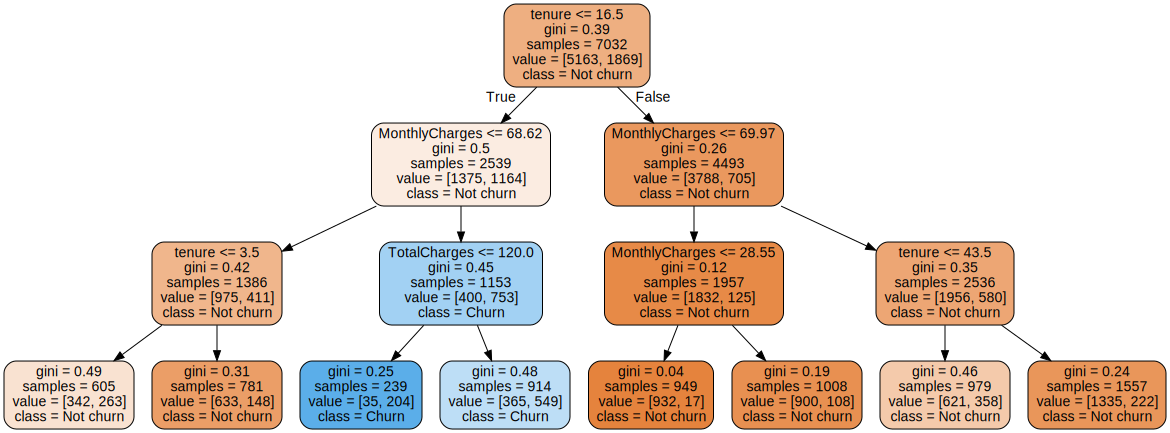

In [33]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn import tree
from graphviz import Source
from IPython.display import SVG,display

#top 3 categorical features
features_cat  = score[score["feature_type"] == "Categorical"]["features"][:3].tolist()

#top 3 numerical features
features_num  = score[score["feature_type"] == "Numerical"]["features"][:3].tolist()


#Function attributes
#columns        - selected columns
#maximum_depth  - depth of tree
#criterion_type - ["gini" or "entropy"]
#split_type     - ["best" or "random"]
#Model Performance - True (gives model output)

def plot_decision_tree(columns,maximum_depth,criterion_type,
                       split_type,model_performance = None) :
    
    #separating dependent and in dependent variables
    dtc_x = df_x[columns]
    dtc_y = df_y[target_col]
    
    #model
    dt_classifier = DecisionTreeClassifier(max_depth = maximum_depth,
                                           splitter  = split_type,
                                           criterion = criterion_type,
                                          )
    dt_classifier.fit(dtc_x,dtc_y)
    
    #plot decision tree
    graph = Source(tree.export_graphviz(dt_classifier,out_file=None,
                                        rounded=True,proportion = False,
                                        feature_names = columns, 
                                        precision  = 2,
                                        class_names=["Not churn","Churn"],
                                        filled = True                         
                                       )
                  )
    
    #model performance
    if model_performance == True :
        telecom_churn_prediction(dt_classifier,
                                 dtc_x,test_X[columns],
                                 dtc_y,test_Y,
                                 columns,"features",threshold_plot = True)
    display(graph)
    
plot_decision_tree(features_num,3,"gini","best")

* Using Top 3 Categorical variables

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

 Classification report : 
               precision    recall  f1-score   support

           0       0.83      0.84      0.84      1268
           1       0.58      0.54      0.56       490

    accuracy                           0.76      1758
   macro avg       0.70      0.69      0.70      1758
weighted avg       0.76      0.76      0.76      1758

Accuracy   Score :  0.7610921501706485
Area under curve :  0.6947675915792185 



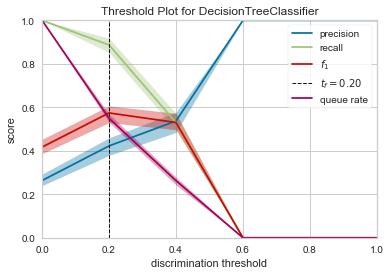

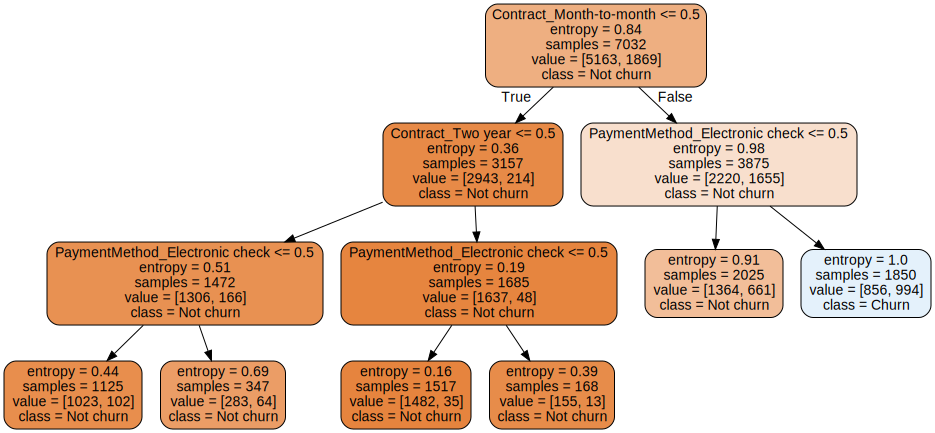

In [34]:
plot_decision_tree(features_cat,3,"entropy","best",
                   model_performance = True ,)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

 Classification report : 
               precision    recall  f1-score   support

           0       0.85      0.74      0.79      1268
           1       0.50      0.66      0.57       490

    accuracy                           0.72      1758
   macro avg       0.68      0.70      0.68      1758
weighted avg       0.75      0.72      0.73      1758

Accuracy   Score :  0.7218430034129693
Area under curve :  0.7038724006952939 



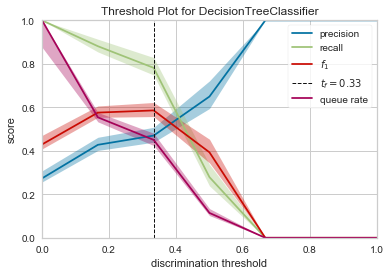

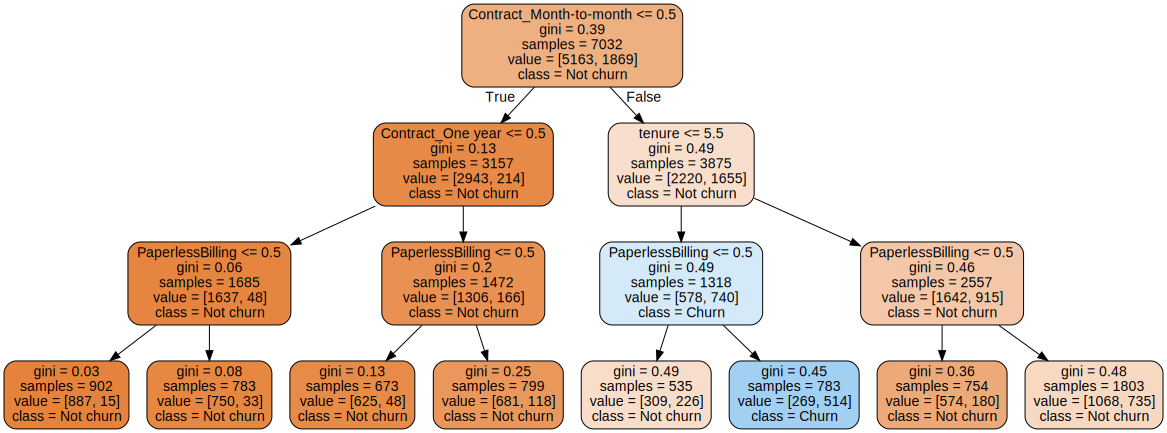

In [35]:
#using contract,tenure and paperless billing variables
columns = ['tenure','Contract_Month-to-month', 'PaperlessBilling',
           'Contract_One year', 'Contract_Two year']

plot_decision_tree(columns,3,"gini","best",model_performance= True)

### KNN Classifier
* Applying knn algorithm to smote oversampled data.

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=1, n_neighbors=5, p=2,
                     weights='uniform')

 Classification report : 
               precision    recall  f1-score   support

           0       0.86      0.73      0.79      1268
           1       0.49      0.68      0.57       490

    accuracy                           0.72      1758
   macro avg       0.67      0.70      0.68      1758
weighted avg       0.75      0.72      0.73      1758

Accuracy Score   :  0.7150170648464164
Area under curve :  0.7047753170668899


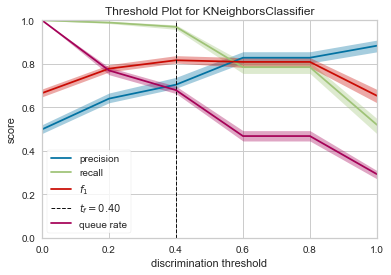

In [36]:
def telecom_churn_prediction_alg(algorithm,training_x,testing_x,
                                 training_y,testing_y,threshold_plot = True) :
    
    #model
    algorithm.fit(training_x,training_y)
    predictions   = algorithm.predict(testing_x)
    probabilities = algorithm.predict_proba(testing_x)
    
    print (algorithm)
    print ("\n Classification report : \n",classification_report(testing_y,predictions))
    print ("Accuracy Score   : ",accuracy_score(testing_y,predictions))
    #confusion matrix
    conf_matrix = confusion_matrix(testing_y,predictions)
    #roc_auc_score
    model_roc_auc = roc_auc_score(testing_y,predictions) 
    print ("Area under curve : ",model_roc_auc)
    fpr,tpr,thresholds = roc_curve(testing_y,probabilities[:,1])
     
    #plot roc curve
    trace1 = go.Scatter(x = fpr,y = tpr,
                        name = "Roc : " + str(model_roc_auc),
                        line = dict(color = ('rgb(22, 96, 167)'),width = 2),
                       )
    trace2 = go.Scatter(x = [0,1],y=[0,1],
                        line = dict(color = ('rgb(205, 12, 24)'),width = 2,
                        dash = 'dot'))
    
    #plot confusion matrix
    trace3 = go.Heatmap(z = conf_matrix ,x = ["Not churn","Churn"],
                        y = ["Not churn","Churn"],
                        showscale  = False,colorscale = "Blues",name = "matrix",
                        xaxis = "x2",yaxis = "y2"
                       )
    
    layout = go.Layout(dict(title="Model performance" ,
                            autosize = False,height = 500,width = 800,
                            showlegend = False,
                            plot_bgcolor  = "rgb(243,243,243)",
                            paper_bgcolor = "rgb(243,243,243)",
                            xaxis = dict(title = "false positive rate",
                                         gridcolor = 'rgb(255, 255, 255)',
                                         domain=[0, 0.6],
                                         ticklen=5,gridwidth=2),
                            yaxis = dict(title = "true positive rate",
                                         gridcolor = 'rgb(255, 255, 255)',
                                         zerolinewidth=1,
                                         ticklen=5,gridwidth=2),
                            margin = dict(b=200),
                            xaxis2=dict(domain=[0.7, 1],tickangle = 90,
                                        gridcolor = 'rgb(255, 255, 255)'),
                            yaxis2=dict(anchor='x2',gridcolor = 'rgb(255, 255, 255)')
                           )
                  )
    data = [trace1,trace2,trace3]
    fig = go.Figure(data=data,layout=layout)
    
    py.iplot(fig)
    
    if threshold_plot == True : 
        visualizer = DiscriminationThreshold(algorithm)
        visualizer.fit(training_x,training_y)
        visualizer.poof()

    
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
telecom_churn_prediction_alg(knn,os_smote_X,test_X,
                             os_smote_Y,test_Y,threshold_plot = True)

### Visualizing a decision tree from random forest classifier

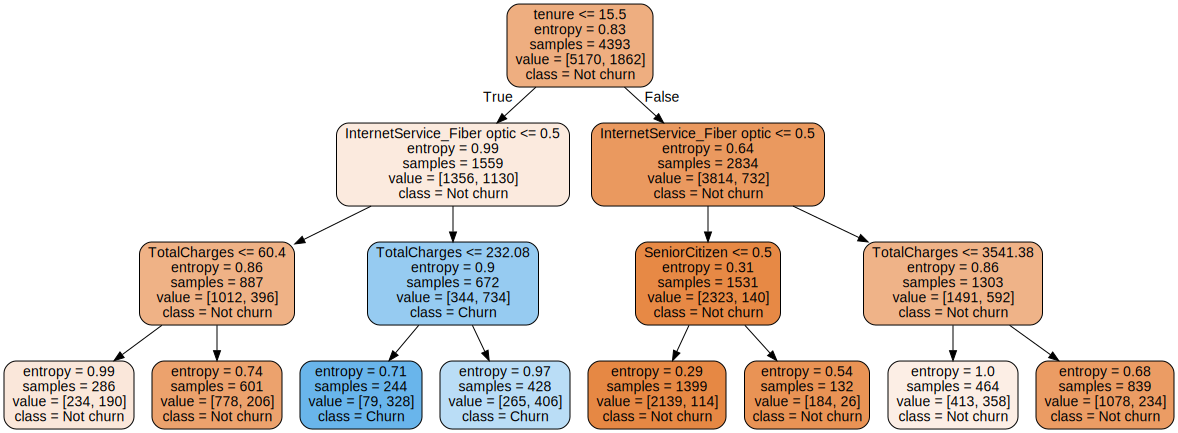

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=3, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

 Classification report : 
               precision    recall  f1-score   support

           0       0.77      0.96      0.85      1268
           1       0.72      0.26      0.38       490

    accuracy                           0.76      1758
   macro avg       0.74      0.61      0.62      1758
weighted avg       0.75      0.76      0.72      1758

Accuracy   Score :  0.764505119453925
Area under curve :  0.6088553402433529 



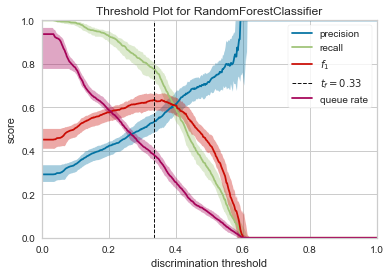

In [37]:
from sklearn.ensemble import RandomForestClassifier

#function attributes
#columns  - column used
#nf_estimators   - The number of trees in the forest.
#estimated_tree  - tree number to be displayed
#maximum_depth   - depth of the tree
#criterion_type  - split criterion type ["gini" or "entropy"]
#Model performance - prints performance of model

def plot_tree_randomforest(columns,nf_estimators,
                           estimated_tree,maximum_depth,
                           criterion_type,model_performance = None) :
    
    dataframe = df_telcom_og[columns + target_col].copy()
    
    #train and test datasets
    rf_x     = dataframe[[i for i in columns if i not in target_col]]
    rf_y     = dataframe[target_col]
    
    #random forest classifier
    rfc   = RandomForestClassifier(n_estimators = nf_estimators,
                                   max_depth = maximum_depth,
                                   criterion = criterion_type,
                                  )
    rfc.fit(rf_x,rf_y)
    
    estimated_tree = rfc.estimators_[estimated_tree]
    
    graph = Source(tree.export_graphviz(estimated_tree,out_file=None,
                                        rounded=True,proportion = False,
                            feature_names = columns, 
                            precision  = 2,
                            class_names=["Not churn","Churn"],
                            filled = True))
    display(graph)
    
    #model performance
    if model_performance == True :
        telecom_churn_prediction(rfc,
                                 rf_x,test_X[columns],
                                 rf_y,test_Y,
                                 columns,"features",threshold_plot = True)
        

cols1 = [ i for i in train_X.columns if i not in target_col + Id_col] 
plot_tree_randomforest(cols1,100,99,3,"entropy",True)

### Random Forest Classifier
* A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and use averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is always the same as the original input sample size but the samples are drawn with replacement .
* Below are the trees produced by random forest model with 10 estimated trees with maximum depth of three for each tree. Each tree produced is slightly different from other.

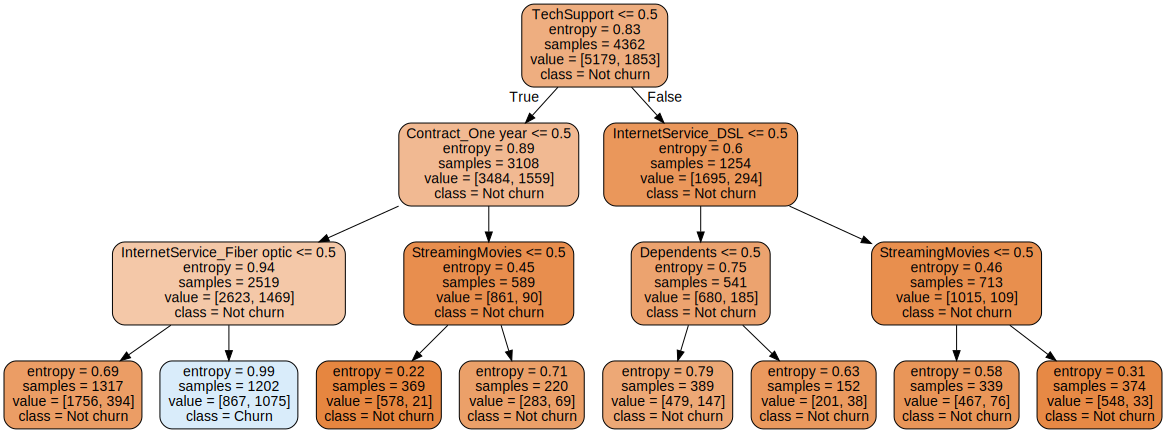

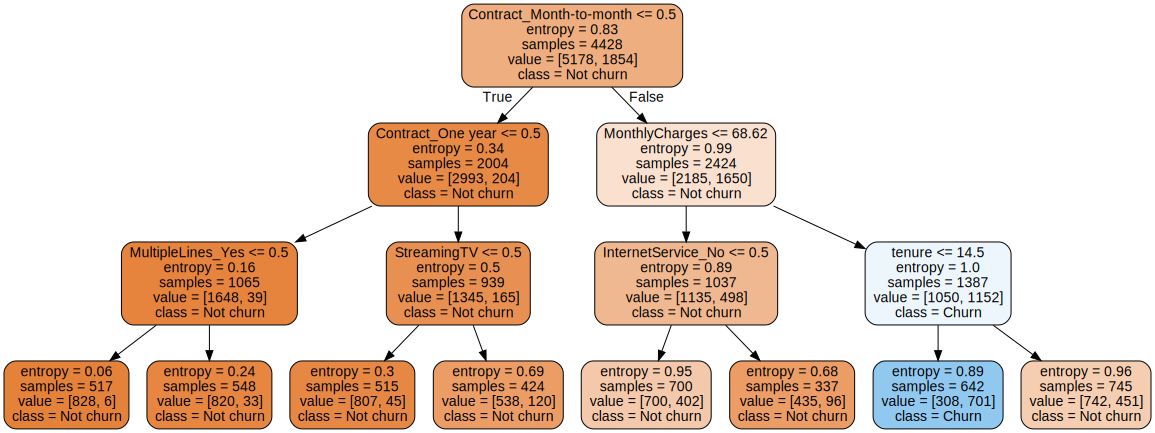

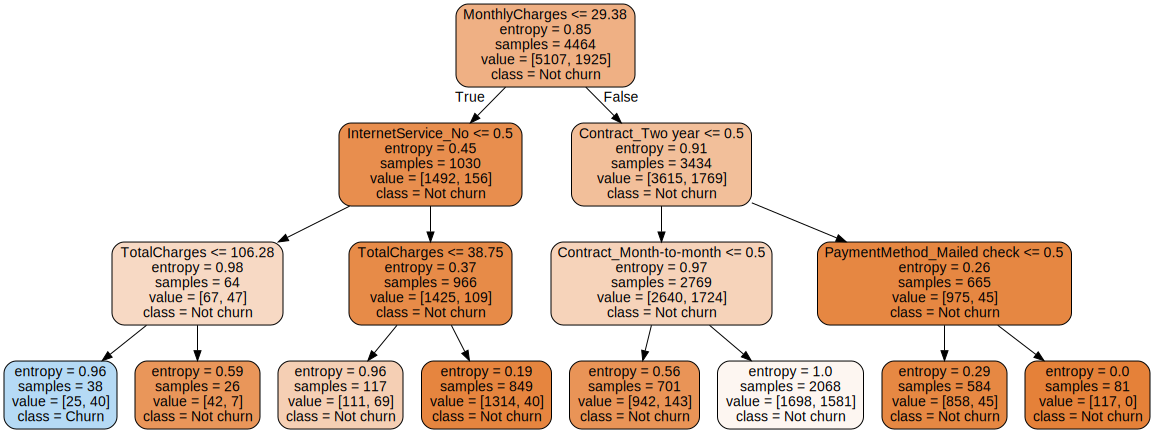

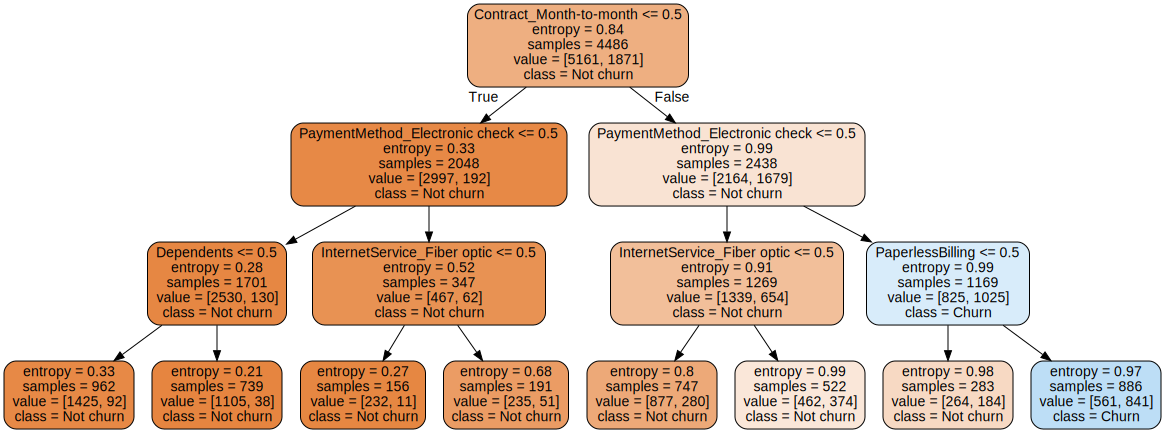

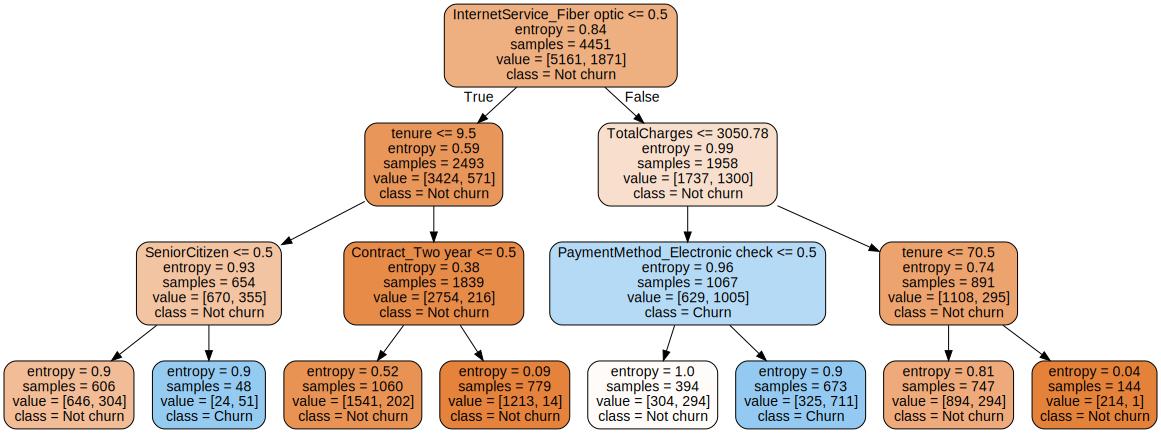

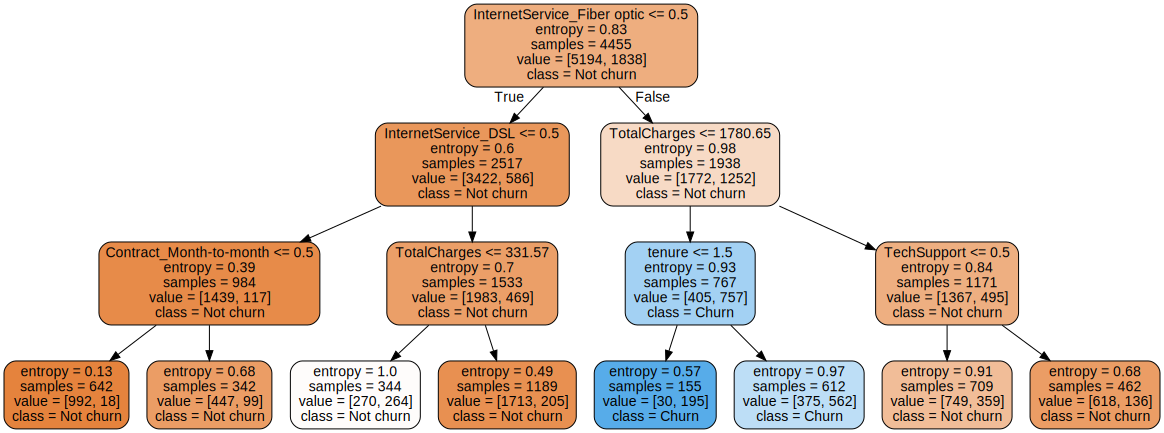

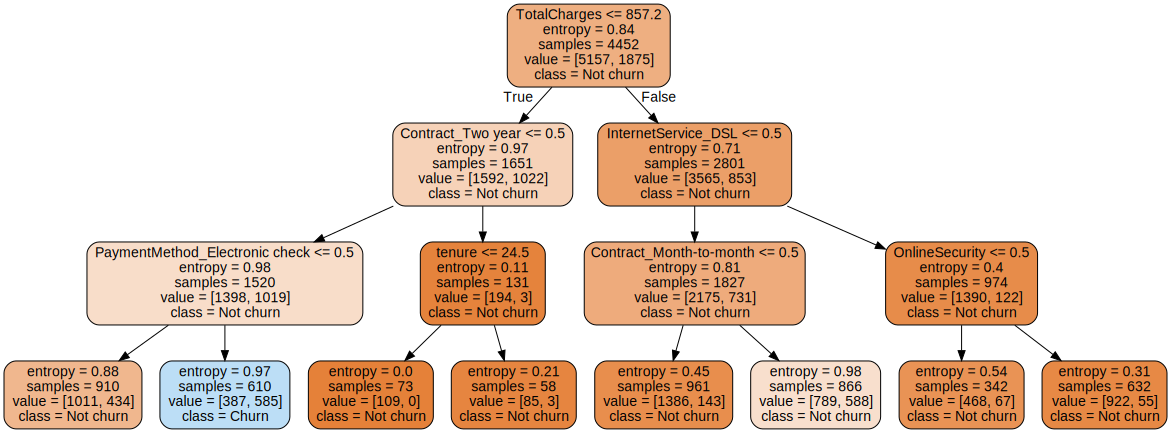

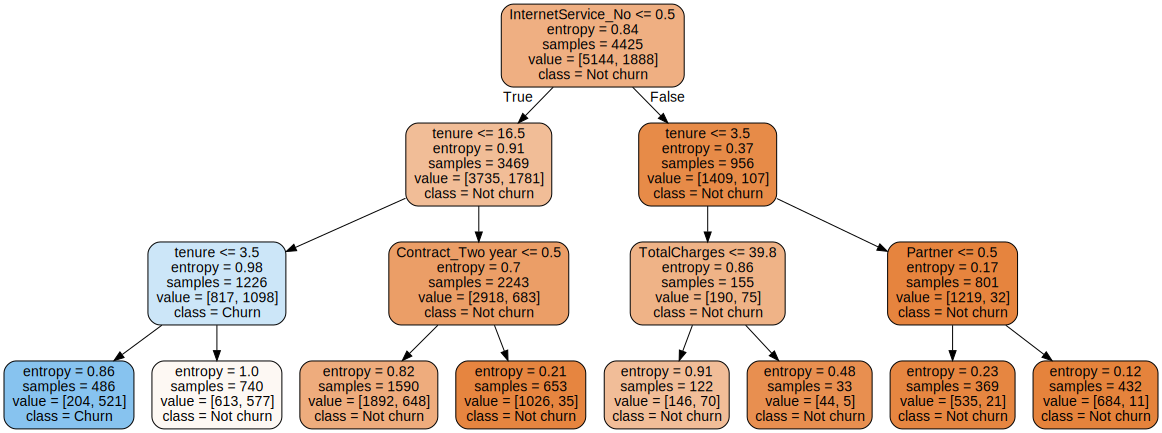

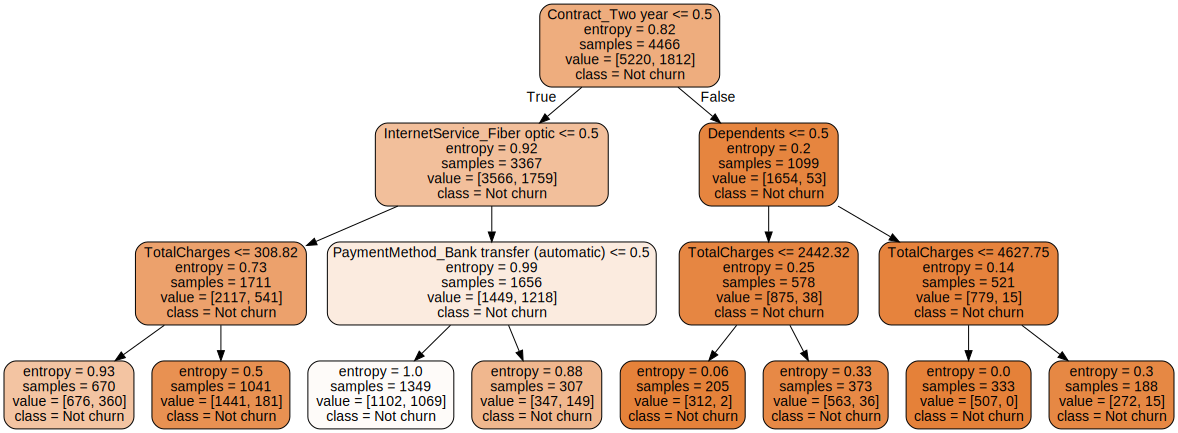

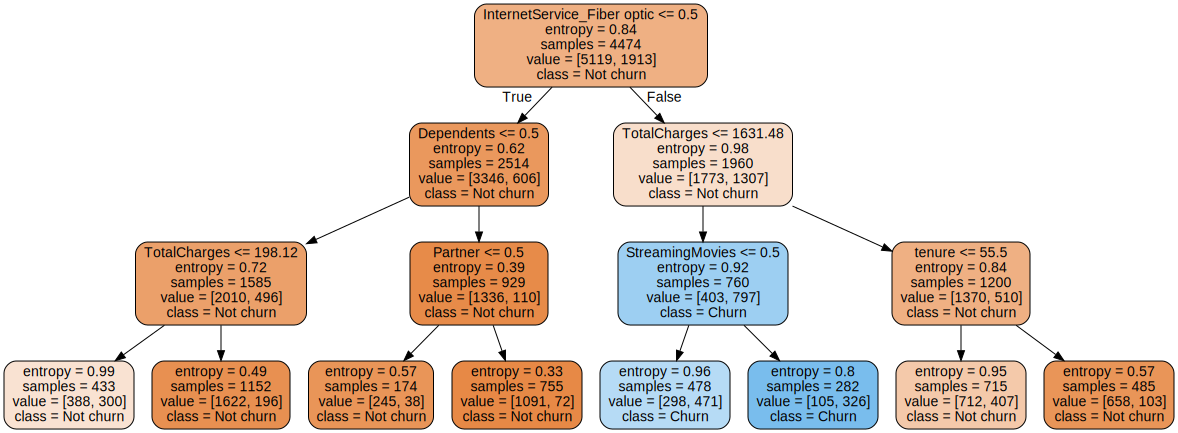

In [39]:
#making 10 trees with random forest.
n = np.arange(0,10).tolist()
cols1 = [ i for i in train_X.columns if i not in target_col + Id_col] 
for i in n :
    plot_tree_randomforest(cols1,10,i,3,"entropy",model_performance=False)

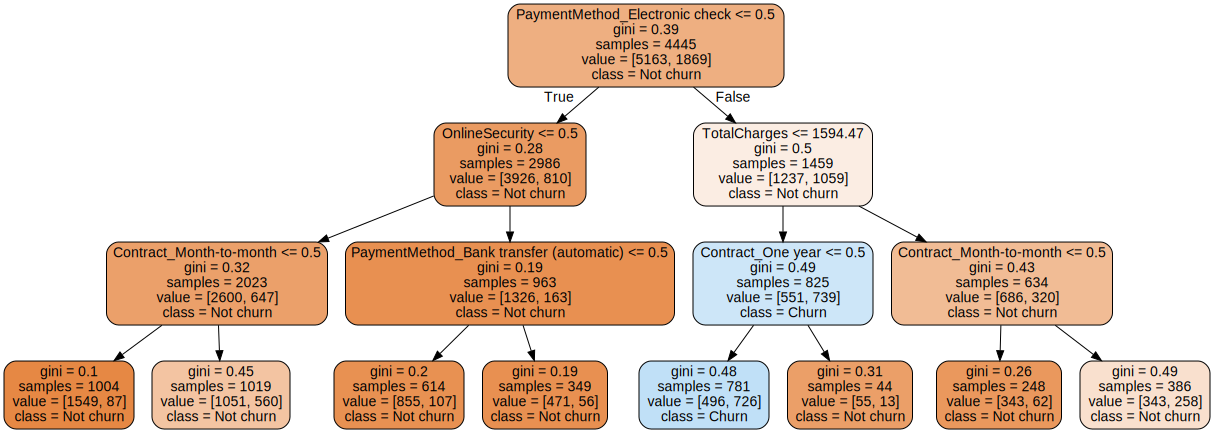

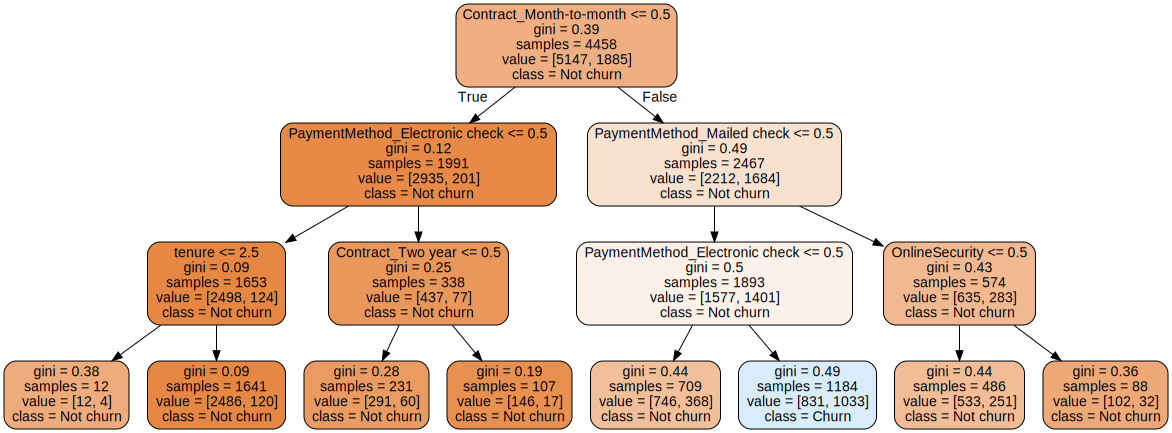

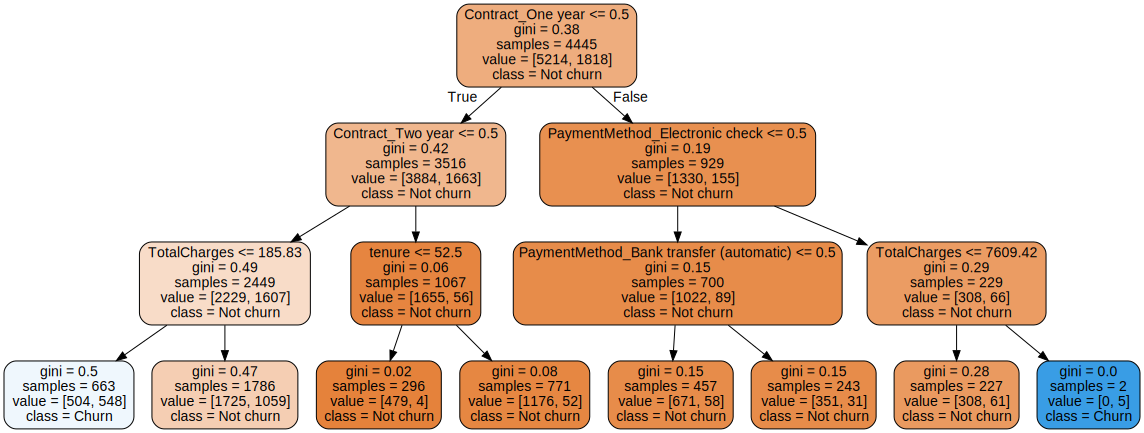

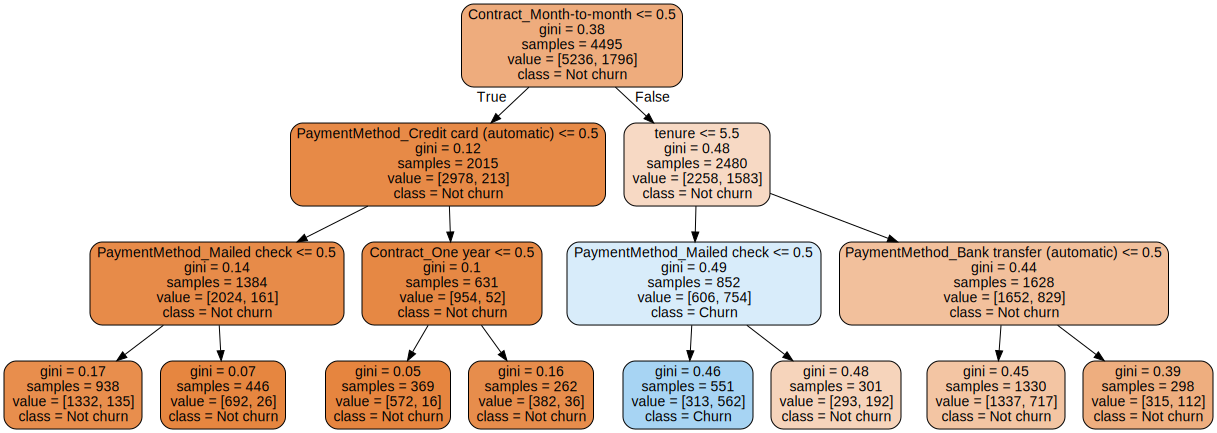

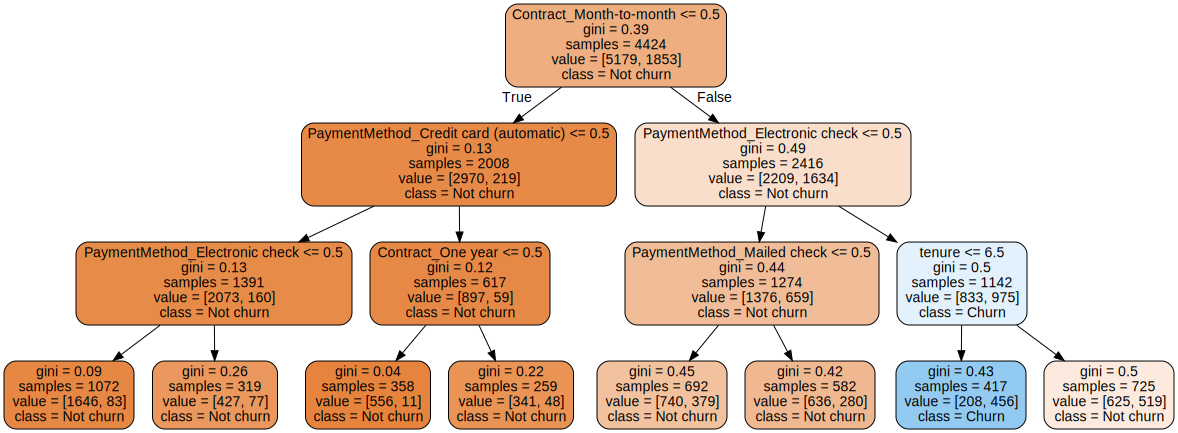

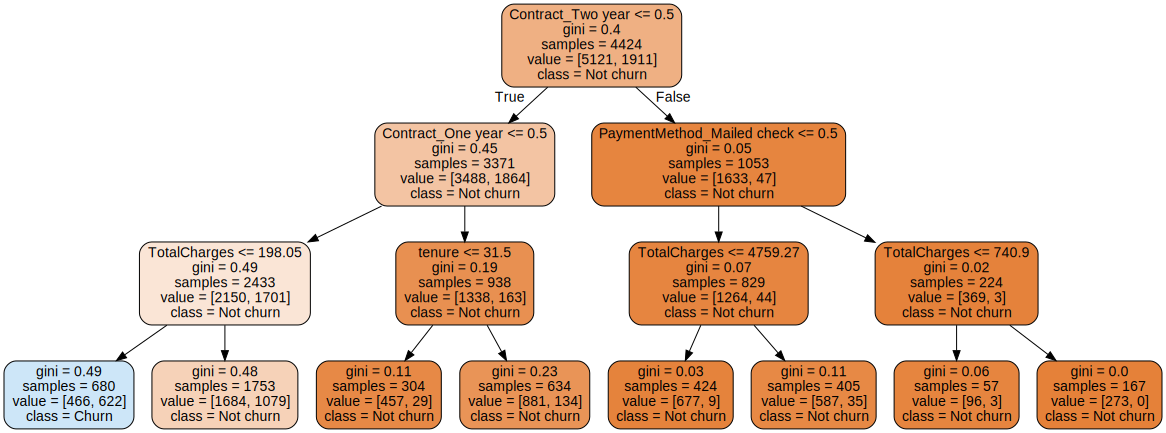

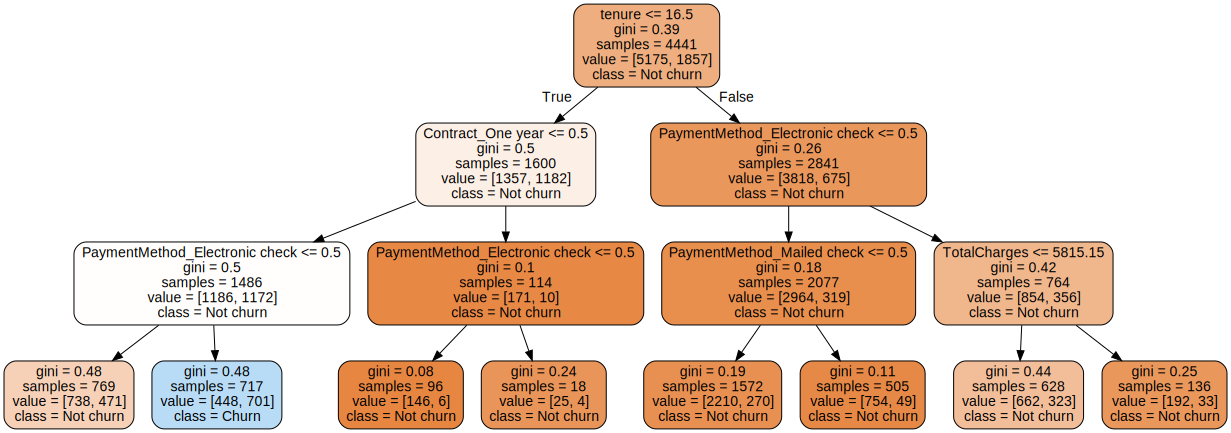

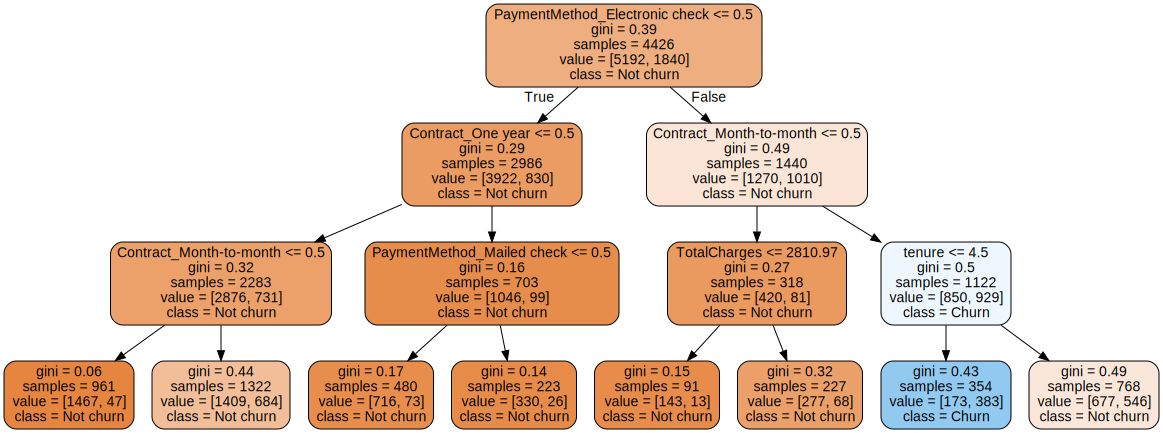

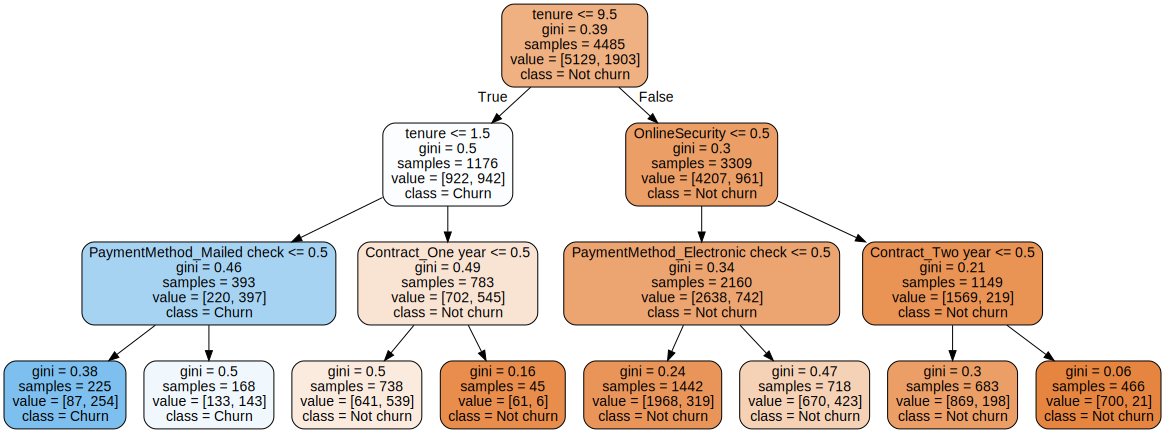

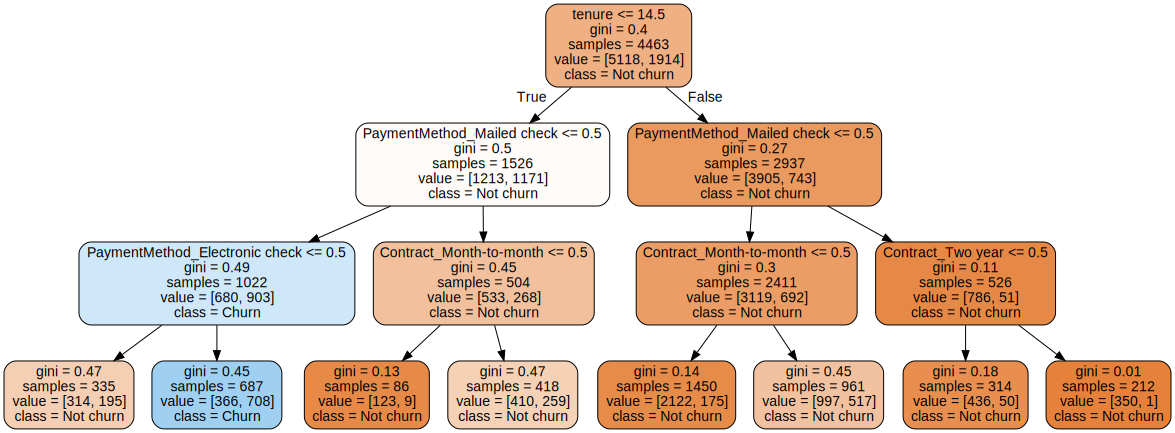

In [40]:
#making 10 trees with random forest for columns 
#selected from recursive feature elimination

n = np.arange(0,10).tolist()
cols = idc_rfe[idc_rfe["rfe_support"] == True]["columns"].tolist() 
for i in n :
    plot_tree_randomforest(cols,10,i,3,"gini",model_performance=False)

### Gaussian Naive Bayes

GaussianNB(priors=None, var_smoothing=1e-09)

 Classification report : 
               precision    recall  f1-score   support

           0       0.90      0.75      0.82      1268
           1       0.55      0.78      0.64       490

    accuracy                           0.76      1758
   macro avg       0.72      0.76      0.73      1758
weighted avg       0.80      0.76      0.77      1758

Accuracy Score   :  0.757679180887372
Area under curve :  0.7631494238073778


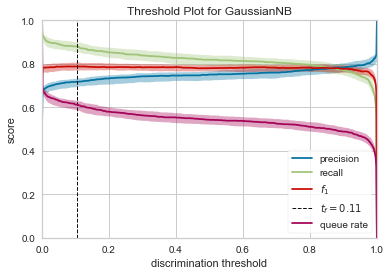

In [41]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB(priors=None)

telecom_churn_prediction_alg(gnb,os_smote_X,test_X,os_smote_Y,test_Y)

### Support Vector Machines
* “Support Vector Machine” (SVM) is a supervised machine learning algorithm which can be used for both classification or regression challenges. it is mostly used in classification problems. 
In this algorithm, we plot each data item as a point in n-dimensional space .where n is number of features you have) with the value of each feature being the value of a particular coordinate. 
Then, we perform classification by finding the hyper-plane that differentiate the two classes 

In [42]:
from sklearn.svm import SVC

#Support vector classifier
#using linear hyper plane
svc_lin  = SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
               decision_function_shape='ovr', degree=3, gamma=1.0, kernel='linear',
               max_iter=-1, probability=True, random_state=None, shrinking=True,
               tol=0.001, verbose=False)

cols = [i for i in telcom.columns if i not in Id_col + target_col]
telecom_churn_prediction(svc_lin,os_smote_X,test_X,os_smote_Y,test_Y,
                         cols,"coefficients",threshold_plot = False)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1.0, kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

 Classification report : 
               precision    recall  f1-score   support

           0       0.87      0.81      0.84      1268
           1       0.58      0.70      0.64       490

    accuracy                           0.78      1758
   macro avg       0.73      0.75      0.74      1758
weighted avg       0.79      0.78      0.78      1758

Accuracy   Score :  0.7770193401592719
Area under curve :  0.7527650807957251 



### Tuning Parameters for Support vector Machines

In [43]:
#tuning parameters
#Support vector classifier
#using non-linear hyper plane("rbf")

svc_rbf  = SVC(C=1.0, kernel='rbf', 
               degree= 3, gamma=1.0, 
               coef0=0.0, shrinking=True,
               probability=True,tol=0.001,
               cache_size=200, class_weight=None,
               verbose=False,max_iter= -1,
               random_state=None)

telecom_churn_prediction_alg(svc_rbf,os_smote_X,test_X,os_smote_Y,test_Y,threshold_plot = False)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1.0, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

 Classification report : 
               precision    recall  f1-score   support

           0       0.83      0.86      0.84      1268
           1       0.59      0.53      0.56       490

    accuracy                           0.77      1758
   macro avg       0.71      0.69      0.70      1758
weighted avg       0.76      0.77      0.76      1758

Accuracy Score   :  0.7667804323094426
Area under curve :  0.6949542908646108


### LightGBM Classifier

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.5, max_depth=7,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=500, objective='binary',
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

 Classification report : 
               precision    recall  f1-score   support

           0       0.83      0.83      0.83      1268
           1       0.56      0.57      0.56       490

    accuracy                           0.76      1758
   macro avg       0.70      0.70      0.70      1758
weighted avg       0.76      0.76      0.76      1758

Accuracy   Score :  0.7554038680318543
Area under curve :  0.6970852378806411 



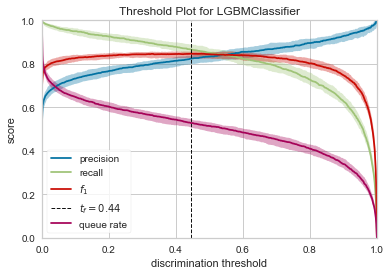

In [44]:
from lightgbm import LGBMClassifier

lgbm_c = LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
                        learning_rate=0.5, max_depth=7, min_child_samples=20,
                        min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
                        n_jobs=-1, num_leaves=500, objective='binary', random_state=None,
                        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
                        subsample_for_bin=200000, subsample_freq=0)

cols = [i for i in telcom.columns if i not in Id_col + target_col]
telecom_churn_prediction(lgbm_c,os_smote_X,test_X,os_smote_Y,test_Y,
                         cols,"features",threshold_plot = True)


### XGBoost Classifier

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.9, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=True, subsample=1, verbosity=1)

 Classification report : 
               precision    recall  f1-score   support

           0       0.83      0.83      0.83      1268
           1       0.56      0.56      0.56       490

    accuracy                           0.75      1758
   macro avg       0.69      0.69      0.69      1758
weighted avg       0.75      0.75      0.75      1758

Accuracy   Score :  0.7525597269624573
Area under curve :  0.6919831970643147 



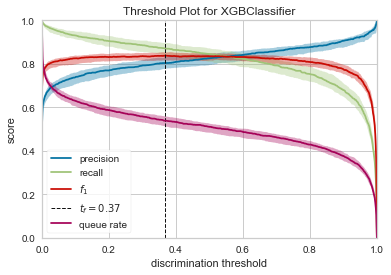

In [46]:
from xgboost import XGBClassifier

xgc = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                    colsample_bytree=1, gamma=0, learning_rate=0.9, max_delta_step=0,
                    max_depth = 7, min_child_weight=1, missing=None, n_estimators=100,
                    n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
                    reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
                    silent=True, subsample=1)


telecom_churn_prediction(xgc,os_smote_X,test_X,os_smote_Y,test_Y,
                         cols,"features",threshold_plot = True)

## Model Performance

### Model Performance Metrics

In [47]:
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score

#gives model report in dataframe
def model_report(model,training_x,testing_x,training_y,testing_y,name) :
    model.fit(training_x,training_y)
    predictions  = model.predict(testing_x)
    accuracy     = accuracy_score(testing_y,predictions)
    recallscore  = recall_score(testing_y,predictions)
    precision    = precision_score(testing_y,predictions)
    roc_auc      = roc_auc_score(testing_y,predictions)
    f1score      = f1_score(testing_y,predictions) 
    kappa_metric = cohen_kappa_score(testing_y,predictions)
    
    df = pd.DataFrame({"Model"           : [name],
                       "Accuracy_score"  : [accuracy],
                       "Recall_score"    : [recallscore],
                       "Precision"       : [precision],
                       "f1_score"        : [f1score],
                       "Area_under_curve": [roc_auc],
                       "Kappa_metric"    : [kappa_metric],
                      })
    return df

#outputs for every model
model1 = model_report(logit,train_X,test_X,train_Y,test_Y,
                      "Logistic Regression(Baseline_model)")
model2 = model_report(logit_smote,os_smote_X,test_X,os_smote_Y,test_Y,
                      "Logistic Regression(SMOTE)")
model3 = model_report(logit_rfe,train_rf_X,test_rf_X,train_rf_Y,test_rf_Y,
                      "Logistic Regression(RFE)")
decision_tree = DecisionTreeClassifier(max_depth = 9,
                                       random_state = 123,
                                       splitter  = "best",
                                       criterion = "gini",
                                      )
model4 = model_report(decision_tree,train_X,test_X,train_Y,test_Y,
                      "Decision Tree")
model5 = model_report(knn,os_smote_X,test_X,os_smote_Y,test_Y,
                      "KNN Classifier")
rfc = RandomForestClassifier(n_estimators = 1000,
                             random_state = 123,
                             max_depth = 9,
                             criterion = "gini")
model6 = model_report(rfc,train_X,test_X,train_Y,test_Y,
                      "Random Forest Classifier")
model7 = model_report(gnb,os_smote_X,test_X,os_smote_Y,test_Y,
                      "Naive Bayes")
model8 = model_report(svc_lin,os_smote_X,test_X,os_smote_Y,test_Y,
                      "SVM Classifier Linear")
model9 = model_report(svc_rbf,os_smote_X,test_X,os_smote_Y,test_Y,
                      "SVM Classifier RBF")
model10 = model_report(lgbm_c,os_smote_X,test_X,os_smote_Y,test_Y,
                      "LGBM Classifier")
model11 = model_report(xgc,os_smote_X,test_X,os_smote_Y,test_Y,
                      "XGBoost Classifier")

#concat all models
model_performances = pd.concat([model1,model2,model3,
                                model4,model5,model6,
                                model7,model8,model9,
                                model10,model11],axis = 0).reset_index()

model_performances = model_performances.drop(columns = "index",axis =1)

table  = ff.create_table(np.round(model_performances,4))

py.iplot(table)

### Compare Model Metrics

In [48]:
model_performances
def output_tracer(metric,color) :
    tracer = go.Bar(y = model_performances["Model"] ,
                    x = model_performances[metric],
                    orientation = "h",name = metric ,
                    marker = dict(line = dict(width =.7),
                                  color = color)
                   )
    return tracer

layout = go.Layout(dict(title = "Model performances",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                        xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     title = "metric",
                                     zerolinewidth=1,
                                     ticklen=5,gridwidth=2),
                        yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     zerolinewidth=1,ticklen=5,gridwidth=2),
                        margin = dict(l = 250),
                        height = 780
                       )
                  )


trace1  = output_tracer("Accuracy_score","#6699FF")
trace2  = output_tracer('Recall_score',"red")
trace3  = output_tracer('Precision',"#33CC99")
trace4  = output_tracer('f1_score',"lightgrey")
trace5  = output_tracer('Kappa_metric',"#FFCC99")

data = [trace1,trace2,trace3,trace4,trace5]
fig = go.Figure(data=data,layout=layout)
py.iplot(fig)



### Confusion Matrices for Models

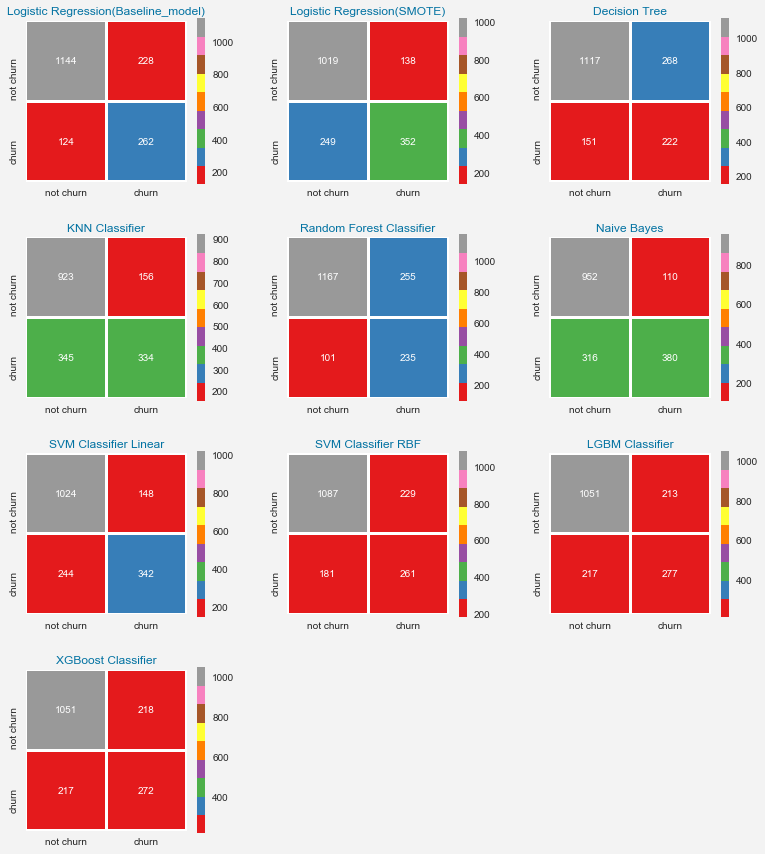

In [49]:
lst    = [logit,logit_smote,decision_tree,knn,rfc,
          gnb,svc_lin,svc_rbf,lgbm_c,xgc]

length = len(lst)

mods   = ['Logistic Regression(Baseline_model)','Logistic Regression(SMOTE)',
          'Decision Tree','KNN Classifier','Random Forest Classifier',"Naive Bayes",
          'SVM Classifier Linear','SVM Classifier RBF', 'LGBM Classifier',
          'XGBoost Classifier']

fig = plt.figure(figsize=(13,15))
fig.set_facecolor("#F3F3F3")
for i,j,k in itertools.zip_longest(lst,range(length),mods) :
    plt.subplot(4,3,j+1)
    predictions = i.predict(test_X)
    conf_matrix = confusion_matrix(predictions,test_Y)
    sns.heatmap(conf_matrix,annot=True,fmt = "d",square = True,
                xticklabels=["not churn","churn"],
                yticklabels=["not churn","churn"],
                linewidths = 2,linecolor = "w",cmap = "Set1")
    plt.title(k,color = "b")
    plt.subplots_adjust(wspace = .3,hspace = .3)

### ROC Curve for Models

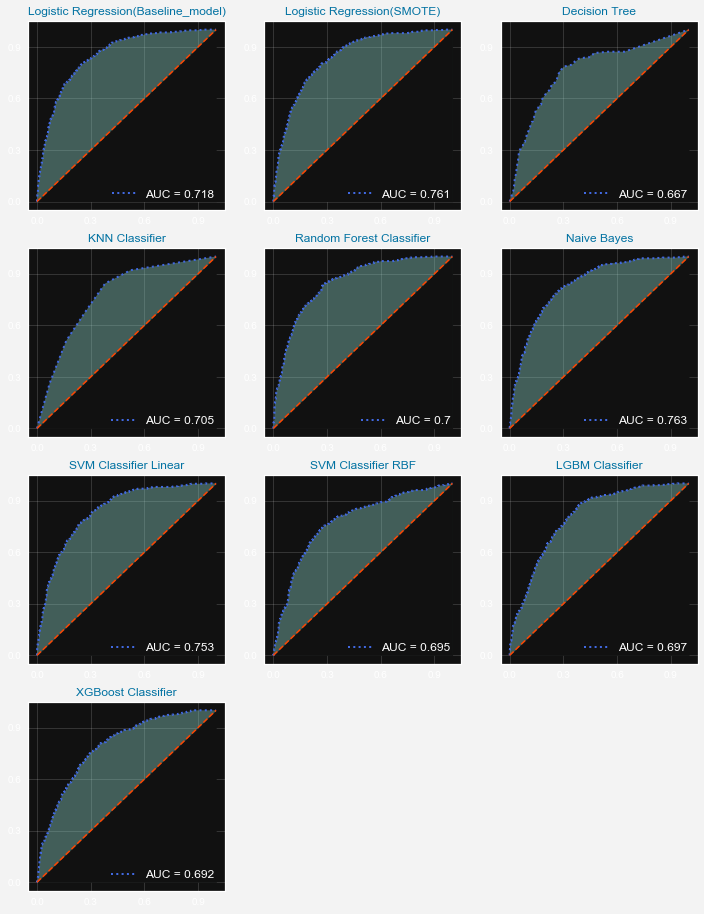

In [50]:
lst    = [logit,logit_smote,decision_tree,knn,rfc,
          gnb,svc_lin,svc_rbf,lgbm_c,xgc]

length = len(lst)

mods   = ['Logistic Regression(Baseline_model)','Logistic Regression(SMOTE)',
          'Decision Tree','KNN Classifier','Random Forest Classifier',"Naive Bayes",
          'SVM Classifier Linear','SVM Classifier RBF', 'LGBM Classifier',
          'XGBoost Classifier']

plt.style.use("dark_background")
fig = plt.figure(figsize=(12,16))
fig.set_facecolor("#F3F3F3")
for i,j,k in itertools.zip_longest(lst,range(length),mods) :
    qx = plt.subplot(4,3,j+1)
    probabilities = i.predict_proba(test_X)
    predictions   = i.predict(test_X)
    fpr,tpr,thresholds = roc_curve(test_Y,probabilities[:,1])
    plt.plot(fpr,tpr,linestyle = "dotted",
             color = "royalblue",linewidth = 2,
             label = "AUC = " + str(np.around(roc_auc_score(test_Y,predictions),3)))
    plt.plot([0,1],[0,1],linestyle = "dashed",
             color = "orangered",linewidth = 1.5)
    plt.fill_between(fpr,tpr,alpha = .4)
    plt.fill_between([0,1],[0,1],color = "k")
    plt.legend(loc = "lower right",
               prop = {"size" : 12})
    qx.set_facecolor("k")
    plt.grid(True,alpha = .15)
    plt.title(k,color = "b")
    plt.xticks(np.arange(0,1,.3))
    plt.yticks(np.arange(0,1,.3))

### Precision Recall Curves

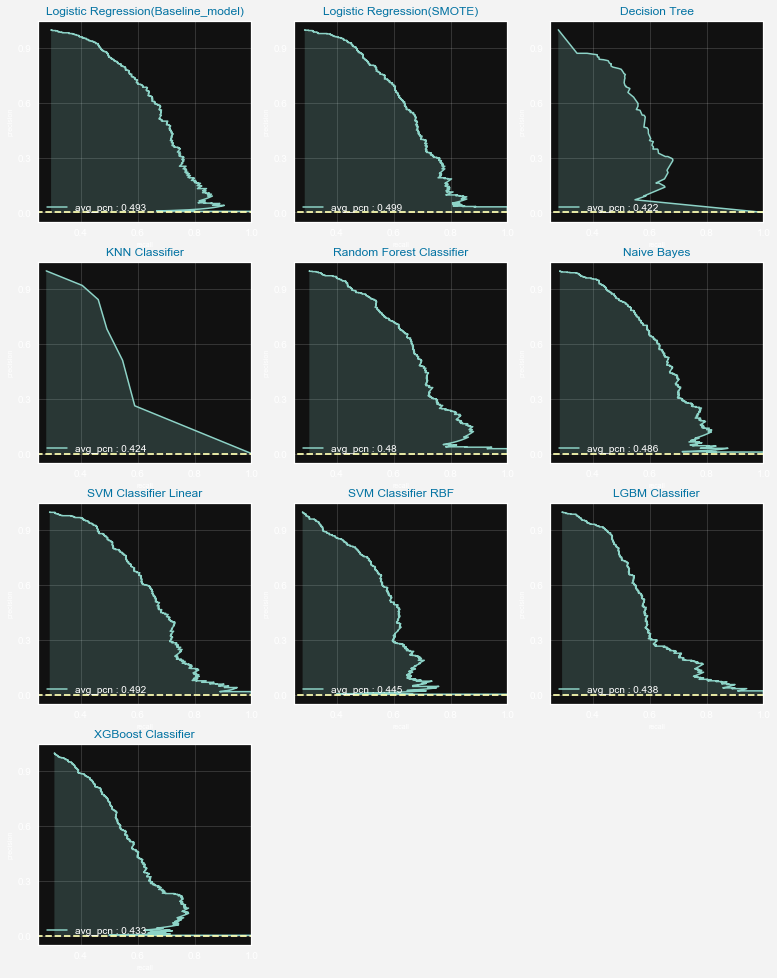

In [51]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score


lst    = [logit,logit_smote,decision_tree,knn,rfc,
          gnb,svc_lin,svc_rbf,lgbm_c,xgc]

length = len(lst)

mods   = ['Logistic Regression(Baseline_model)','Logistic Regression(SMOTE)',
          'Decision Tree','KNN Classifier','Random Forest Classifier',"Naive Bayes",
          'SVM Classifier Linear','SVM Classifier RBF', 'LGBM Classifier',
          'XGBoost Classifier']

fig = plt.figure(figsize=(13,17))
fig.set_facecolor("#F3F3F3")
for i,j,k in itertools.zip_longest(lst,range(length),mods) :
    
    qx = plt.subplot(4,3,j+1)
    probabilities = i.predict_proba(test_X)
    predictions   = i.predict(test_X)
    recall,precision,thresholds = precision_recall_curve(test_Y,probabilities[:,1])
    plt.plot(recall,precision,linewidth = 1.5,
             label = ("avg_pcn : " + 
                      str(np.around(average_precision_score(test_Y,predictions),3))))
    plt.plot([0,1],[0,0],linestyle = "dashed")
    plt.fill_between(recall,precision,alpha = .2)
    plt.legend(loc = "lower left",
               prop = {"size" : 10})
    qx.set_facecolor("k")
    plt.grid(True,alpha = .15)
    plt.title(k,color = "b")
    plt.xlabel("recall",fontsize =7)
    plt.ylabel("precision",fontsize =7)
    plt.xlim([0.25,1])
    plt.yticks(np.arange(0,1,.3))